In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow as tf

In [47]:
def datapipe(path):
    df = pd.read_csv(path)
    print(df.head())
    print(df.info())
    print(df.describe())
    print(df.WELL_ID.unique())
    print(df.shape)
    df['BLPD'] = df['BOPD'] + df['BWPD']  # Assume BOPD and BWPD are in your CSV
    return df

In [48]:
path = '/Users/rianrachmanto/miniforge3/project/esp_forecast_LSTM/data/wells_data_final.csv'
df = datapipe(path)

   Unnamed: 0        DATE           WELL_ID  CURRENT  PRESS_DESC  FREQUENCY  \
0           0  2019-02-25  DEEPWATER-000XAR    72.42     4252.87      57.44   
1           1  2019-02-26  DEEPWATER-000XAR    72.77     4203.62      57.44   
2           2  2019-02-27  DEEPWATER-000XAR    72.29     4271.55      57.45   
3           3  2019-02-28  DEEPWATER-000XAR    72.29     4271.55      57.45   
4           4  2019-03-01  DEEPWATER-000XAR    72.29     4271.55      57.45   

   PRESS_INT  TEMP_INT  TEMP_MOT  OUT_VOLT  ...  GOR(MSFC/BPPD)  \
0    1443.97    222.71    281.56       0.0  ...       123.54874   
1    1414.84    222.80    281.09       0.0  ...       123.54874   
2    1449.17    222.72    281.55       0.0  ...       123.54874   
3    1449.17    222.72    281.55       0.0  ...       123.54874   
4    1449.17    222.72    281.55       0.0  ...       123.54874   

   GLR(SCF/BFPD)   API  FREC(Hz)  PIP(PSI)  INTAKE_DEPTH  AMPERAGE     PUMP  \
0       6.177437  18.6      57.5    1453.0 

In [49]:
def edit_data(df):
    dfed = df.sort_values(by='DATE', ascending=True)
    plt.figure(figsize=(20,10))
    sns.lineplot(x='DATE', y='BLPD', data=dfed)
    plt.ylabel('BLPD')
    ax2 = plt.twinx()
    sns.lineplot(x='DATE', y='CURRENT', data=dfed, color='red')
    ax2.set_ylabel('CURRENT')
    plt.legend(['BLPD', 'CURRENT'])
    plt.show()
    return dfed


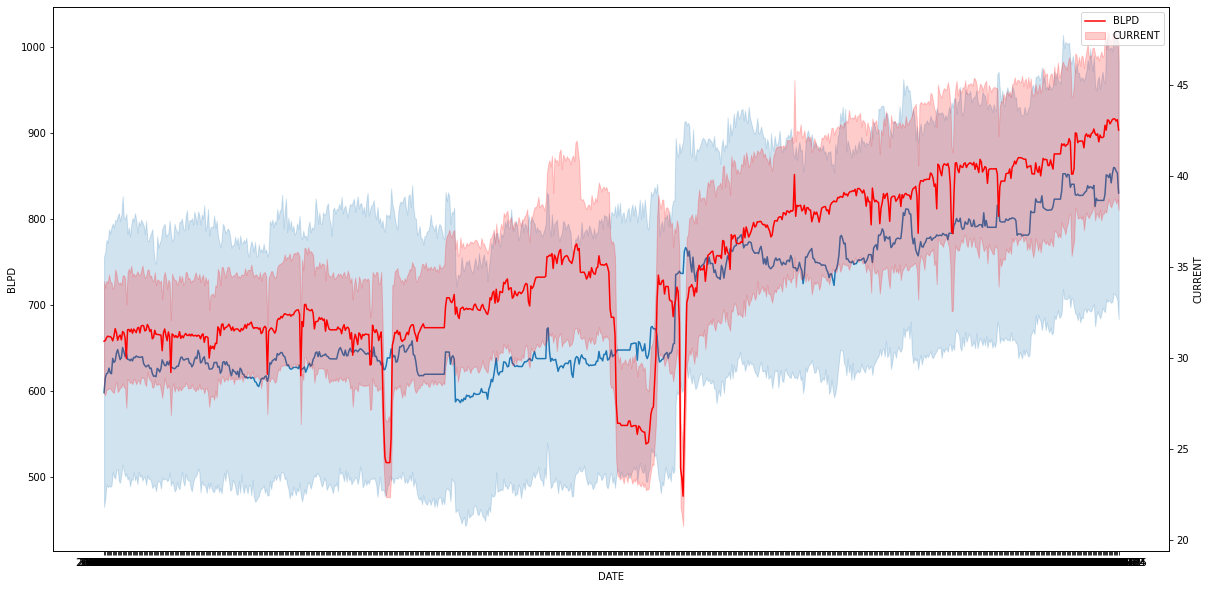

In [50]:
dfed=edit_data(df)

In [51]:
def choose_feat(dfed):
    df_lstm = dfed[['DATE','CURRENT']]
    df_lstm.set_index('DATE', inplace=True)
    print(df_lstm.head())
    return dfed 

In [52]:
df_lstm=choose_feat(dfed)

            CURRENT
DATE               
2019-02-25    72.42
2019-02-25    33.05
2019-02-25    24.08
2019-02-25    28.38
2019-02-25    20.00


In [53]:
#use minmaxscaler on df_lstm on column CURRENT
scaler = MinMaxScaler()
df_lstm['CURRENT'] = scaler.fit_transform(df_lstm[['CURRENT']])

In [54]:
def split_data(df_lstm):
    #drop date column
    df_lstm.drop(columns='DATE', inplace=True)
    #reset index
    df_lstm.reset_index(drop=True, inplace=True)
    train_size = int(len(df_lstm) * 0.8)
    test_size = len(df_lstm) - train_size
    train, test = df_lstm.iloc[0:train_size], df_lstm.iloc[train_size:len(df_lstm)]
    print(train.shape, test.shape)
    return train, test

In [55]:
train,test=split_data(df_lstm)

(47183, 26) (11796, 26)


In [56]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1): 
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [57]:
look_back = 5
X_train_lstm, y_train_lstm = create_dataset(train, look_back)
X_test_lstm, y_test_lstm = create_dataset(test, look_back)

InvalidIndexError: (slice(0, 5, None), 0)